In [52]:
#-*- coding:utf-8 -*-

# pandas import 
import pandas as pd

# numpy import
import numpy as np

# Graph lib import 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

# heatmap
import seaborn as sns

# 피어슨 상관계수 
import scipy.stats as stats

# OLS Regression
import statsmodels.formula.api as smf

# Logistic Regression
import statsmodels.api as sm

# pre-required pip3 install factor-analyzer
from factor_analyzer import FactorAnalyzer

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False


# 각 열, 응답문항에 대하여 집계 한 데이터 return
def q13a_agg_col(col_name, agg_type, each_cnt, df, surfix):
    data = {}
    for i in range(1, each_cnt):
        col_idx = f'{i:02}'            # lpad 0, 2 length
        col_nm = col_name + col_idx 
        data[col_nm + '_' + surfix] = df[col_nm].groupby(df[col_nm]).agg(agg_type)
    return data

# cronbach alpha 
def cronbach_alpha(df):
    df_corr = df.corr()
    N = df.shape[1]
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
        mean_r = np.mean(rs)
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha


# 피어슨 상관계수를 구한뒤 dataFrame 으로 변환한다.
def pearson_frame(index_col, data_frame, each_cnt, col_list):
    data = {}
    for i in range(1, each_cnt):
        pear_val = stats.pearsonr(data_frame.corr()[index_col], data_frame.corr()[col_list[i-1]])
        data[col_list[i-1]] = pear_val
        
    res_data = pd.DataFrame.from_dict(data)
    res_data = res_data.rename(index={0 : '피어슨 상관계수 r', 1 : 'p-value'})
    return res_data

# raw data 5점 척도 변환

# one hot encoding 
def change_one_hot(origin_df, each_cnt, prefix):
    convert_df = origin_df
    for i in range(1, each_cnt):
        col_idx = f'{i:02}'
        col_nm = prefix + col_idx
        convert_df[col_nm] = convert_df[col_nm].apply(lambda x : 0 if x <= 3 else 1)
    return convert_df 


def change_one_hot_by_median(origin_df, each_cnt, prefix):
    convert_df = origin_df
    for i in range(1, each_cnt):
        col_idx = f'{i:02}'
        col_nm = prefix + col_idx
        
        # 중앙값 기준으로 -> 중앙값보다 작거나 같으면 0, 중앙값보다 크면 1 이다.
        this_median = convert_df[col_nm].mode()
        convert_df[col_nm] = convert_df[col_nm].apply(lambda x : 0 if x <= int(this_median) else 1)
    return convert_df


def change_one_hot_by_mean(origin_df, each_cnt, prefix):
    convert_df = origin_df
    for i in range(1, each_cnt):
        col_idx = f'{i:02}'
        col_nm = prefix + col_idx
        
        # 중앙값 기준으로 -> 중앙값보다 작거나 같으면 0, 중앙값보다 크면 1 이다.
        this_median = convert_df[col_nm].mean()
        convert_df[col_nm] = convert_df[col_nm].apply(lambda x : 0 if x <= int(this_median) else 1)
    return convert_df


def change_one_hot_by_mode(origin_df, each_cnt, prefix):
    convert_df = origin_df
    for i in range(1, each_cnt):
        col_idx = f'{i:02}'
        col_nm = prefix + col_idx
        
        # 최빈값 기준으로 -> 최빈값보다 작으면 0, 최빈값보다 크면 1 이다.
        this_median = convert_df[col_nm].mode()
        convert_df[col_nm] = convert_df[col_nm].apply(lambda x : 0 if x < int(this_median) else 1)
    return convert_df


# view to heatmap
def view_to_heatmap(x_size, y_size, df_corr ):
    plt.figure(figsize=(x_size,y_size))


    # 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
    mask = np.zeros_like(df_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # 히트맵을 그린다
    sns.heatmap(df_corr, 
                cmap = 'RdYlBu_r', 
                annot = True,   # 실제 값을 표시한다
                mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
                linewidths=.5,  # 경계면 실선으로 구분하기
                cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
                vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
               )

In [19]:
# csv 파일을 읽어서 데이터 프레임으로 변환한다.
raw_data = pd.read_csv('./data/raw_data.csv')

raw_data['q13a04'] = raw_data['q13a04'].fillna(0).astype(int)

# 데이터 변환시, 원본데이터 오염을 막기위해 DataFrame을 복사하여 처리한다.
statistics_df = raw_data.copy()

In [20]:
statistics_df

,NO,q1,q1a,q5,q13a01,q13a02,q13a03,q13a04,q13a05,q13a06,...,q15,q16a,q16b,chasu,nat,city,sex,edu,job,age
0,1,2,3,6,3,5,4,5,3,3,...,3,4,4,12,12,1328,1,3,3,4
1,2,2,3,1,4,4,3,4,4,5,...,4,4,4,12,3,401,1,1,3,3
2,3,1,1,6,5,5,5,5,5,5,...,5,3,5,12,12,1304,1,1,99,2
3,4,1,1,1,4,4,4,5,4,3,...,4,4,5,12,3,401,1,2,8,1
4,5,2,3,1,3,4,5,5,5,4,...,5,4,4,12,3,401,2,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11990,11991,2,2,6,5,4,4,5,4,4,...,4,4,4,1,10,1001,1,2,12,2
11991,11992,2,2,5,5,5,5,3,4,4,...,4,4,4,1,15,5057,2,2,8,1
11992,11993,2,3,5,5,5,5,5,5,5,...,5,5,5,1,9,961,2,2,12,1
11993,11994,2,4,6,5,5,5,3,5,5,...,5,5,5,1,97,5350,1,2,2,2


In [25]:
statistics_df.columns = ['NO', 'q1' ,'q1a', 'q5'
                         ,'q13a01' ,'q13a02' ,'q13a03','q13a04' ,'q13a05'
                         ,'q13a06' ,'q13a07' ,'q13a08','q13a09','q13a10' 
                         ,'q13a11' ,'q13a12' ,'q13a13','q13a14'
                         ,'chasu','nat','city','sex','edu','job','age']



"""
재방문 여부	q1
재방문 횟수	q1a
방문 목적 -> q5
출입국 절차 만족	q13a01
대중교통 만족	q13a02
숙박 만족	q13a03
음식 만족	q13a04
쇼핑 만족	q13a05
관광지매력도 만족	q13a06
관광서비스 만족	q13a07
언어소통 만족	q13a08
여행경비 만족	q13a09
치안 만족	q13a10
재방문 의사	q14          q13a11 
추천 의사	q15          q13a12
여행 전 한국 이미지	q16a   q13a13
여행 후 한국 이미지	q16b   q13a14
조사기간월	chasu 
거주국별	nat
거주도시	city
성별	sex
학력별	edu
직업별	job
연령별	age

6 -> 비즈니스
1 -> 관광
"""

print('***'*20)

************************************************************


In [23]:
statistics_df

,NO,q1,q1a,q5,q13a01,q13a02,q13a03,q13a04,q13a05,q13a06,...,q13a12,q13a13,q13a14,chasu,nat,city,sex,edu,job,age
0,1,2,3,6,3,5,4,5,3,3,...,3,4,4,12,12,1328,1,3,3,4
1,2,2,3,1,4,4,3,4,4,5,...,4,4,4,12,3,401,1,1,3,3
2,3,1,1,6,5,5,5,5,5,5,...,5,3,5,12,12,1304,1,1,99,2
3,4,1,1,1,4,4,4,5,4,3,...,4,4,5,12,3,401,1,2,8,1
4,5,2,3,1,3,4,5,5,5,4,...,5,4,4,12,3,401,2,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11990,11991,2,2,6,5,4,4,5,4,4,...,4,4,4,1,10,1001,1,2,12,2
11991,11992,2,2,5,5,5,5,3,4,4,...,4,4,4,1,15,5057,2,2,8,1
11992,11993,2,3,5,5,5,5,5,5,5,...,5,5,5,1,9,961,2,2,12,1
11993,11994,2,4,6,5,5,5,3,5,5,...,5,5,5,1,97,5350,1,2,2,2


In [45]:
filter_non = statistics_df[( ( statistics_df['q13a01'] == 8 ) 
                           | ( statistics_df['q13a02'] == 8 )
                           | ( statistics_df['q13a03'] == 8 )
                           | ( statistics_df['q13a04'] == 8 )
                           | ( statistics_df['q13a05'] == 8.0 )
                           | ( statistics_df['q13a06'] == 8 )
                           | ( statistics_df['q13a07'] == 8 )
                           | ( statistics_df['q13a08'] == 8 )
                           | ( statistics_df['q13a09'] == 8 )
                           | ( statistics_df['q13a10'] == 8 )
                           | ( statistics_df['q13a11'] == 8 ) 
                            ) != True ]

filter_non # 필터링 결과값 저장 변수

filter_business = filter_non[filter_non['q5'] == 6]

# 방문 목적 비즈니스
filter_business

filter_business.to_csv(r'./business.csv')


filter_trip = filter_non[filter_non['q5'] == 1]


# 방문 목적 여행
filter_trip

filter_trip.to_csv(r'./trip.csv')

In [10]:
# 재방문 의사컬럼에 대한 최빈값을 구한다.
mode_val = statistics_df['q13a11'].mode()

mode_val # mode_val[0] -> 최빈값, 정수형

filter_df = filter_non[filter_non['q13a11'] > (mode_val[0])]  # 4 보다 큰 응답,[매우 만족]
# q13a11 의 값은 5로 고정된다.

"""
재방문 의사가 있는 방한 외국인 기준 필터링 결과 4300 건의 데이터 필터링
"""

filter_df

,NO,q1,q1a,q13a01,q13a02,q13a03,q13a04,q13a05,q13a06,q13a07,...,q13a12,q13a13,q13a14,chasu,nat,city,sex,edu,job,age
2,3,1,1,5,5,5,5,5,5,5,...,5,3,5,12,12,1304,1,1,99,2
4,5,2,3,3,4,5,5,5,4,4,...,5,4,4,12,3,401,2,2,3,1
5,6,1,1,5,5,5,5,5,5,5,...,5,5,5,12,14,1796,1,2,12,1
6,7,2,2,5,5,5,5,5,5,5,...,5,5,5,12,14,1701,1,2,5,2
8,9,1,1,4,5,5,5,5,5,5,...,5,5,5,12,14,1703,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11973,11974,1,1,5,5,5,5,5,4,5,...,5,5,5,1,1,7,2,2,3,4
11984,11985,1,1,4,4,5,5,5,5,5,...,5,5,5,1,16,5513,1,1,5,2
11988,11989,2,4,5,5,3,5,5,4,4,...,5,5,5,1,10,1006,2,2,7,3
11992,11993,2,3,5,5,5,5,5,5,5,...,5,5,5,1,9,961,2,2,12,1


In [11]:
statistics_cp = q13a_agg_col('q13a', 'count', 15, filter_df.copy(), 'fq')

revisit_fq_df = pd.DataFrame(statistics_cp)
revisit_fq_df
revisit_fq_df.columns = ["출입국 절차 만족", "숙박 만족", 
                         "대중교통 만족", "쇼핑 만족", "음식 만족",
                         "관광지매력도 만족", "관광서비스 만족", "언어소통 만족",
                         "여행경비 만족", "치안 만족" , "재방문 의사", "추천의사", "여행전 한국이미지", "여행후 한국이미지"]

revisit_fq_df

,출입국 절차 만족,숙박 만족,대중교통 만족,쇼핑 만족,음식 만족,관광지매력도 만족,관광서비스 만족,언어소통 만족,여행경비 만족,치안 만족,재방문 의사,추천의사,여행전 한국이미지,여행후 한국이미지
1,29,2,3,3,2,2,6,36,6,2,NaN,NaN,5,3
2,75,26,8,23,5,9,25,170,57,9,NaN,8.0,18,4
3,303,261,220,226,148,240,404,977,631,175,NaN,49.0,477,61
4,1247,1120,1292,1272,1270,1279,1334,1484,1530,968,NaN,693.0,1853,1049
5,2646,2891,2777,2776,2875,2770,2531,1633,2076,3146,4300.0,3550.0,1947,3183


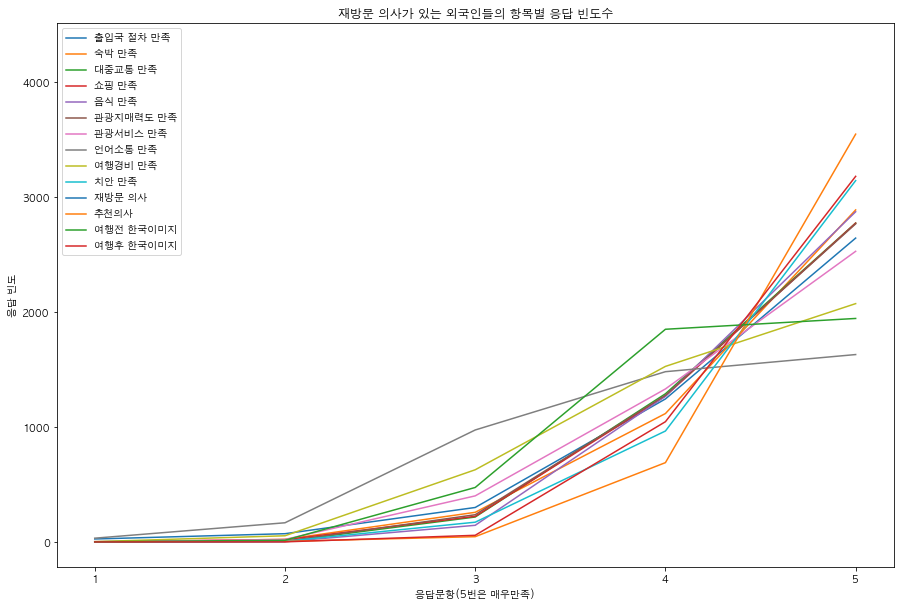

In [12]:
revisit_fq_df.plot(figsize=(15,10))
plt.title("재방문 의사가 있는 외국인들의 항목별 응답 빈도수")
plt.xlabel("응답문항(5번은 매우만족)")
plt.ylabel("응답 빈도")
plt.xticks(range(1,6,1))
plt.show()

In [13]:
# q13a11 => 재방문 의사 5점 척도
select_p = filter_df.copy().iloc[:, [3,4,5,6,7,8,9,10,11,12]]

select_p.columns = ["출입국 절차 만족", "숙박 만족", 
                    "대중교통 만족", "쇼핑 만족", "음식 만족",
                    "관광지매력도 만족", "관광서비스 만족", "언어소통 만족",
                    "여행경비 만족", "치안 만족"]

select_p

,출입국 절차 만족,숙박 만족,대중교통 만족,쇼핑 만족,음식 만족,관광지매력도 만족,관광서비스 만족,언어소통 만족,여행경비 만족,치안 만족
2,5,5,5,5,5,5,5,5,5,5
4,3,4,5,5,5,4,4,4,4,4
5,5,5,5,5,5,5,5,3,5,5
6,5,5,5,5,5,5,5,3,4,5
8,4,5,5,5,5,5,5,3,4,5
...,...,...,...,...,...,...,...,...,...,...
11973,5,5,5,5,5,4,5,5,5,5
11984,4,4,5,5,5,5,5,5,5,5
11988,5,5,3,5,5,4,4,3,3,4
11992,5,5,5,5,5,5,5,5,5,5


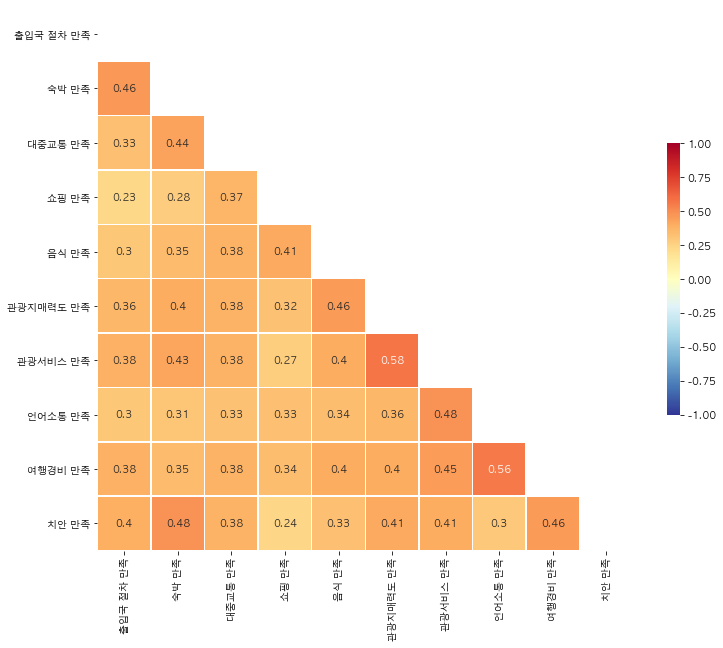

In [15]:
view_to_heatmap(12,10, select_p.corr())

In [16]:
# 재방문 의사가 있는 외국인대상 상관관계 cronbach_alpha 계산
cronbach_alpha(select_p)

0.8590536922284568

In [17]:
col_list_p = ["출입국 절차 만족", "숙박 만족", 
              "대중교통 만족", "쇼핑 만족", "음식 만족",
              "관광지매력도 만족", "관광서비스 만족", "언어소통 만족",
              "여행경비 만족", "치안 만족"]

pearson_by_revisit_at = pearson_frame('관광지매력도 만족', select_p, 11, col_list_p)
pearson_by_revisit_at




,출입국 절차 만족,숙박 만족,대중교통 만족,쇼핑 만족,음식 만족,관광지매력도 만족,관광서비스 만족,언어소통 만족,여행경비 만족,치안 만족
피어슨 상관계수 r,-0.116926,-0.043039,-0.130612,-0.231460,0.139391,1.0,0.470293,-0.122583,-0.110188,-0.004258
p-value,0.747692,0.906026,0.719111,0.519945,0.700938,0.0,0.170167,0.735843,0.761868,0.990685


In [18]:
one_hot = change_one_hot_by_mode(filter_df.copy(), 15,'q13a' )
one_hot

,NO,q1,q1a,q13a01,q13a02,q13a03,q13a04,q13a05,q13a06,q13a07,...,q13a12,q13a13,q13a14,chasu,nat,city,sex,edu,job,age
2,3,1,1,1,1,1,1,1,1,1,...,1,0,1,12,12,1304,1,1,99,2
4,5,2,3,0,0,1,1,1,0,0,...,1,0,0,12,3,401,2,2,3,1
5,6,1,1,1,1,1,1,1,1,1,...,1,1,1,12,14,1796,1,2,12,1
6,7,2,2,1,1,1,1,1,1,1,...,1,1,1,12,14,1701,1,2,5,2
8,9,1,1,0,1,1,1,1,1,1,...,1,1,1,12,14,1703,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11973,11974,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,7,2,2,3,4
11984,11985,1,1,0,0,1,1,1,1,1,...,1,1,1,1,16,5513,1,1,5,2
11988,11989,2,4,1,1,0,1,1,0,0,...,1,1,1,1,10,1006,2,2,7,3
11992,11993,2,3,1,1,1,1,1,1,1,...,1,1,1,1,9,961,2,2,12,1


In [71]:
# 방문 목적 비즈니스

# filter_business
# filter_business.to_csv(r'./business.csv')
# filter_trip = filter_non[filter_non['q5'] == 1]
# filter_trip = change_one_hot_by_mode(filter_trip.copy(), 15,'q13a' )

# 방문 목적 여행
# filter_trip

# filter_trip.to_csv(r'./filter_trip_one_hot_by_mode.csv')
# filter_trip.to_csv(r'./trip.csv')

# filter_business = change_one_hot_by_mode(filter_business.copy(), 15,'q13a' )
# filter_business.to_csv(r'./filter_business_one_hot_by_mode.csv')

In [72]:
# filter_business_mean = filter_business.copy()
# onhot_business = change_one_hot_by_mean(filter_business_mean.copy(), 15, 'q13a')
# onhot_business.to_csv(r'./filter_business_one_hot_by_mean.csv')

# filter_trip_mean = filter_trip.copy()
# filter_trip_mean = change_one_hot_by_mean(filter_trip_mean.copy(), 15, 'q13a')
# filter_trip_mean.to_csv(r'./filter_trip_one_hot_by_mean.csv')

In [73]:
# onehot_business_sample = onhot_business.sample(n=100)

# n = 500 개

In [74]:
filter_business

,NO,q1,q1a,q5,q13a01,q13a02,q13a03,q13a04,q13a05,q13a06,...,q13a12,q13a13,q13a14,chasu,nat,city,sex,edu,job,age
0,1,2,3,6,3,5,4,5,3,3,...,3,4,4,12,12,1328,1,3,3,4
2,3,1,1,6,5,5,5,5,5,5,...,5,3,5,12,12,1304,1,1,99,2
9,10,1,1,6,5,5,4,4,5,5,...,5,3,5,12,14,1703,2,1,4,0
21,22,1,1,6,5,5,4,4,5,5,...,5,3,5,12,16,5513,1,2,2,3
23,24,2,4,6,4,4,3,4,4,3,...,5,5,5,12,10,1002,1,3,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11986,11987,2,2,6,5,5,3,3,4,4,...,4,4,5,1,97,5075,1,1,12,2
11987,11988,2,4,6,5,5,4,5,4,5,...,4,4,5,1,9,802,2,3,5,1
11988,11989,2,4,6,5,5,3,5,5,4,...,5,5,5,1,10,1006,2,2,7,3
11990,11991,2,2,6,5,4,4,5,4,4,...,4,4,4,1,10,1001,1,2,12,2


In [65]:
filter_business_sample = filter_business.copy().sample(n = 100)

In [66]:
filter_business_sample

,NO,q1,q1a,q5,q13a01,q13a02,q13a03,q13a04,q13a05,q13a06,...,q13a12,q13a13,q13a14,chasu,nat,city,sex,edu,job,age
9031,9032,2,4,6,5,5,5,4,5,4,...,5,5,5,3,4,402,1,2,2,3
3848,3849,1,1,6,5,5,5,5,5,5,...,5,5,5,9,14,1702,1,4,1,1
2776,2777,1,1,6,5,3,4,5,4,4,...,4,4,4,10,8,601,1,2,2,4
10813,10814,2,2,6,5,4,4,3,3,5,...,4,3,4,2,13,1517,1,3,4,2
411,412,2,4,6,5,5,5,4,5,5,...,5,3,5,12,16,5236,1,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4235,4236,1,1,6,4,4,4,4,4,4,...,4,3,3,8,12,1301,1,3,5,4
2226,2227,1,1,6,4,4,3,4,3,5,...,4,4,4,10,11,1112,2,3,12,5
11787,11788,1,1,6,5,5,5,5,5,5,...,5,4,5,1,14,1701,1,2,6,2
6418,6419,2,2,6,5,5,5,4,4,4,...,4,3,4,6,5,505,1,2,6,3
